# **Forecasting: Store-Sales**

This project aims to forecast the sales of a company's stores in Ecuador. We work with Time Series to predictions the sales, used tools of the **Pandas**. The Model learning  is the kind Hydrid,  it be first model `RandomForestRegressor` while the second model is `LinearRegression`. 



# **Setting** #

Setup of the system  and necessary libraries.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

%matplotlib inline

# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex3 import *

 # Allows the use of display() for DataFrames
# from IPython.core.interactiveshell import InteractiveShell

# InteractiveShell.ast_node_interactivity = "all"


# Setup notebook
from pathlib import Path
from IPython.display import display

from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_periodogram, seasonal_plot


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


from scipy.signal import periodogram
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import OneHotEncoder


from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor # make for microsoft
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error as mae 
from sklearn.metrics import  mean_squared_log_error as msle




# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# **Get Data** #

The data is in  [Kaggle Store sales](https://www.kaggle.com/c/store-sales-time-series-forecasting). 


In [2]:
# Paths
comp_dir = Path('../input/store-sales-time-series-forecasting')

# timeInitial
timeInitial = '2013'

# Get datas
holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
    index_col='date'
)

hol = holidays_events.to_period('D')
hol = hol[hol.locale == 'National'] # I'm only taking National holiday so there's no false positive.
hol = hol.groupby(hol.index).first() # Removing duplicated holiday at the same date 

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family','onpromotion', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

oil = pd.read_csv(
    comp_dir / 'oil.csv',
    usecols = ['date', 'dcoilwtico'],
    dtype={'dcoilwtico': 'float32'    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

 
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc[timeInitial :'2017-08-15', ['description'] ]
    .assign(description=lambda x: x.description.cat.remove_unused_categories()) # assign new columns
)

df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
# Rearray to period

transactions =  pd.read_csv( comp_dir / 'transactions.csv',
                            parse_dates = ['date'], 
                            infer_datetime_format = True, 
                            )

oil['date'] = oil.date.dt.to_period('D')
oil = oil.set_index(['date']).sort_index()
oil=oil.squeeze()

store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()




#  **Exploratory Data Analysis** #

Information preliminar about  `store_sales`.

In [3]:
display(store_sales.info())
display( store_sales.describe().T)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3000888 entries, ('1', 'AUTOMOTIVE', Period('2013-01-01', 'D')) to ('9', 'SEAFOOD', Period('2017-08-15', 'D'))
Data columns (total 2 columns):
 #   Column       Dtype  
---  ------       -----  
 0   sales        float32
 1   onpromotion  uint32 
dtypes: float32(1), uint32(1)
memory usage: 34.4 MB


None

,count,mean,std,min,25%,50%,75%,max
sales,3000888.0,356.758392,1093.275879,0.0,0.0,11.0,195.847252,124717.0
onpromotion,3000888.0,2.602770,12.218882,0.0,0.0,0.0,0.000000,741.0


In [4]:
store_sales['sales'].head()

def salesDecompose(df, share_type='sales', samples=250, period=30):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. Period=24 daily seasonality | Period=24*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()
    

### Sales Decompose
In this section shown to sales decompose in three parts;  Observed, Trend and Seasonality, in a range time of  one year. 

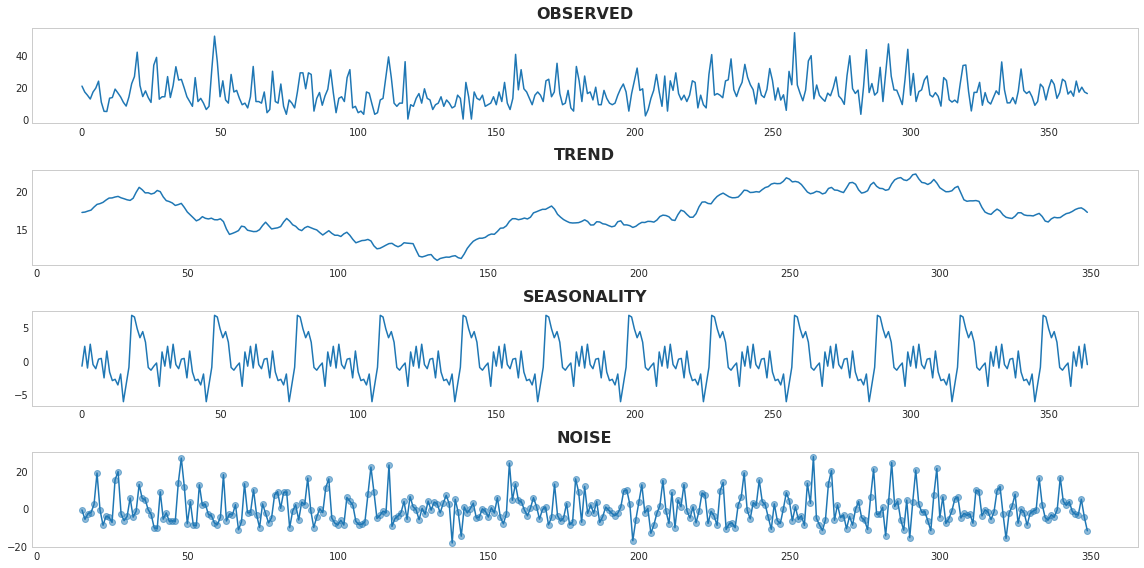

In [5]:
salesDecompose(store_sales, samples= 365, period = 30 )

Here, we maked average sales from time initial `2013`. Then we show Partial Correlation of Lags,  noting the most  significant ones.  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1684 entries, 2013-01-01 to 2017-08-15
Freq: D
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sales        1684 non-null   float32
 1   onpromotion  1684 non-null   float64
dtypes: float32(1), float64(1)
memory usage: 32.9 KB


None

,sales,onpromotion
date,,
2013-01-01,1.409438,0.0
2013-01-02,278.390808,0.0
2013-01-03,202.840195,0.0
2013-01-04,198.911148,0.0
2013-01-05,267.873230,0.0


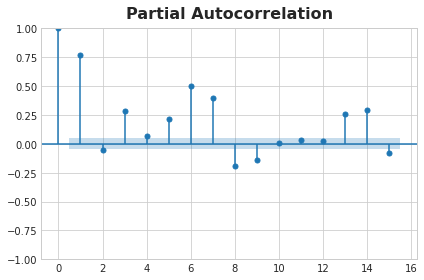

In [6]:
# transactions per store
transactions.info()


# average sales 
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc[timeInitial:]
)


plot_pacf(average_sales.sales, lags=15)


display(average_sales.info())
#ax = average_sales.plot(**plot_params, alpha = 0.5,  title='Averange Sales', ylabel='Items Sold')
#ax.legend();

average_sales.head()

The price's Oil from initial time.

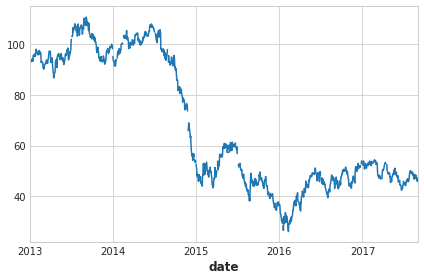

In [7]:
oil[timeInitial:].plot()
plt.show()




In [8]:
dfOil = pd.DataFrame(oil)
dfOil.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1218 entries, 2013-01-01 to 2017-08-31
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dcoilwtico  1175 non-null   float32
dtypes: float32(1)
memory usage: 46.6 KB


<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1218 entries, 2013-01-01 to 2017-08-31
Freq: D
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dcoilwtico  1217 non-null   float32
 1   ma_oil      1211 non-null   float64
dtypes: float32(1), float64(1)
memory usage: 56.1 KB


<AxesSubplot:xlabel='date'>

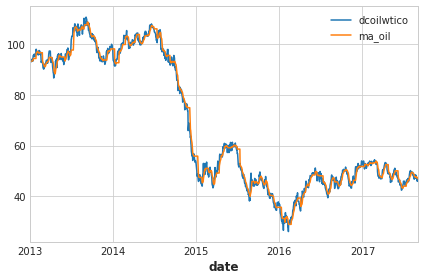

In [9]:
dfOil['ma_oil'] = dfOil['dcoilwtico'].rolling(7).mean() # calculating mean by oil ( there are NaNs  values)
dfOil.fillna(method='ffill', inplace=True)
dfOil.info()

dfOil.plot()
#dfOil.ma_oil[timeInitial:].plot()

# **Model with Oil** #


We started create training  data, used `CalendarFourier`. For determine seasonal we take care `DeterministicProcess`. Futher, we add the Holiday days. 

In [10]:
sdate = '2017-06-15'
edate = '2017-08-15'
y = store_sales.unstack(['store_nbr', 'family']).loc[sdate:] 


# y = y.join( oil.rename('Oil') , on='date').fillna(method = 'bfill')

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)

X = dp.in_sample()

X1 = X.copy() 

#holidays = holidays.groupby(holidays.index).first() # Removing duplicated holiday at the same date

## Feature Engineering for Holidays

In [11]:
#calendar = X.join(hol)
calendar = pd.DataFrame(index = pd.date_range('2013-01-01', '2017-08-31')).to_period('D')

calendar['NewYear'] = (calendar.index.dayofyear == 1)

calendar['dofw'] = calendar.index.dayofweek # Weekly day
calendar['wd'] = True
calendar.loc[calendar.dofw > 4, 'wd'] = False # not work day

calendar = calendar.join(hol) # Joining calendar with holiday dataset
calendar['dofw'] = calendar.index.dayofweek # Weekly day
calendar['wd'] = 1
calendar.loc[calendar.dofw > 4, 'wd'] = 0 # If it's saturday or sunday then it's not Weekday
calendar.loc[calendar.type == 'Work Day', 'wd'] = 1 # If it's Work Day event then it's a workday
calendar.loc[calendar.type == 'Transfer', 'wd'] = 0 # If it's Transfer event then it's not a work day
calendar.loc[calendar.type == 'Bridge', 'wd'] = 0 # If it's Bridge event then it's not a work day
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = 0 # If it's holiday and the holiday is not transferred then it's holiday
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True), 'wd'] = 1 # If it's holiday and transferred then it's not holiday
calendar = pd.get_dummies(calendar, columns = ['dofw'], drop_first = True) # One-hot encoding (Make sure to drop one of the columns by 'drop_first = True')
calendar = pd.get_dummies(calendar, columns = ['type']) # One-hot encoding for type holiday (No need to drop one of the columns because there's a "No holiday" already)
calendar.drop(['locale', 'locale_name', 'description', 'transferred'], axis = 1, inplace = True) # Unused columns


school_season = [] # Feature for school fluctuations
for i, r in calendar.iterrows() :
    if i.month in [4, 5, 8, 9] :
        school_season.append(1)
    else :
        school_season.append(0)
calendar['school_season'] = school_season

calendar

,NewYear,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,school_season
2013-01-01,True,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2013-01-02,False,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-03,False,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2013-01-04,False,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2013-01-05,False,1,0,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,False,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2017-08-28,False,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2017-08-29,False,1,1,0,0,0,0,0,0,0,0,0,0,0,1
2017-08-30,False,1,0,1,0,0,0,0,0,0,0,0,0,0,1


In [12]:
#X = X.join( oil.rename('Oil') , on='date').fillna(method = 'bfill')


oilInitial = dfOil.loc[sdate:] 


fourier = CalendarFourier(freq='M', order=4)
dpOil = DeterministicProcess(
    index=oilInitial.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)

Xoil = dpOil.in_sample()


Missing Values Count

In [13]:

missingValueCount = X1.isnull().sum()
print('Num_null: ' , missingValueCount.sum() )
#X2 = X2.dropna()
#X2 = X2.fillna(0)


Num_null:  0


Add new columns to train set. From Lag's graph, we consider seven Lags. While Oil, we saw that three Lags are enough.

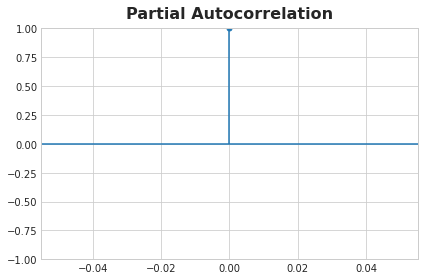

In [14]:
calendar['Oil'] = dfOil['ma_oil']


_ = plot_pacf(calendar.Oil, lags = 12) # Lagplot oil price (Feature Engineering)

# first 
n_lags = 3
for l in range(1, n_lags + 1) :
    calendar[f'oil_lags{l}'] = calendar.Oil.shift(l)


    
#X2.Oil.fillna(value = oil.mean() , inplace=True ) # drop values NaNs
#X2.fillna(method='ffill') # drop values NaNs

#X2['salesLag1'] = average_sales.sales.shift(periods=1, freq='D')
#X2['salesLag2'] = average_sales.sales.shift(2)


In [15]:
X1 = X1.join(calendar)

In [16]:
X1['Onpromotion'] = average_sales['onpromotion']
X1['salesLag7'] = average_sales.sales.shift(7)

X2 = X1.join( Xoil , on='date', rsuffix='RT').fillna(method = 'ffill')

#X = X.join( oil.rename('Oil') , on='date').fillna(method = 'bfill')

#X1.fillna(method='ffill') # drop values NaNs

X2.dropna(how='any', axis=0, inplace=True) # drop values NaNs


In [17]:
dateRange =  X2.index

# train set and target train
y_train = y.loc[dateRange]
Xtrain=X2.copy()

#  **Hybrid Model**

First  model to get us seasonal information. Meanwhile, the second model will take care of training the rest of the data.
While, second model to  training  rest of train set.

# Model Bizen's

In [18]:
from joblib import Parallel, delayed
import warnings

# Import necessary library
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor

# SEED for reproducible result
SEED = 5

class CustomRegressor():
    
    def __init__(self, n_jobs=-1, verbose=0):
        
        self.n_jobs = n_jobs
        self.verbose = verbose
        
        self.estimators_ = None
        
    def _estimator_(self, X, y):
    
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        if y.name[2] == 'SCHOOL AND OFFICE SUPPLIES': # Because SCHOOL AND OFFICE SUPPLIES has weird trend, we use decision tree instead.
            r1 = ExtraTreesRegressor(n_estimators = 225, n_jobs=-1, random_state=SEED)
            r2 = RandomForestRegressor(n_estimators = 225, n_jobs=-1, random_state=SEED)
            b1 = BaggingRegressor(base_estimator=r1,
                                  n_estimators=10,
                                  n_jobs=-1,
                                  random_state=SEED)
            b2 = BaggingRegressor(base_estimator=r2,
                                  n_estimators=10,
                                  n_jobs=-1,
                                  random_state=SEED)
            model = VotingRegressor([('et', b1), ('rf', b2)]) # Averaging the result
        else:
            ridge = Ridge(fit_intercept=True, solver='auto', alpha=0.75, normalize=True, random_state=SEED)
            svr = SVR(C = 0.2, kernel = 'rbf')
            
            model = VotingRegressor([('ridge', ridge), ('svr', svr)]) # Averaging result
        model.fit(X, y)

        return model

    def fit(self, X, y):
        from tqdm.auto import tqdm
        
        
        if self.verbose == 0 :
            self.estimators_ = Parallel(n_jobs=self.n_jobs, 
                                  verbose=0,
                                  )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in range(y.shape[1]))
        else :
            print('Fit Progress')
            self.estimators_ = Parallel(n_jobs=self.n_jobs, 
                                  verbose=0,
                                  )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in tqdm(range(y.shape[1])))
        return
    
    def predict(self, X):
        from tqdm.auto import tqdm
        if self.verbose == 0 :
            y_pred = Parallel(n_jobs=self.n_jobs, 
                              verbose=0)(delayed(e.predict)(X) for e in self.estimators_)
        else :
            print('Predict Progress')
            y_pred = Parallel(n_jobs=self.n_jobs, 
                              verbose=0)(delayed(e.predict)(X) for e in tqdm(self.estimators_))
        
        return np.stack(y_pred, axis=1)

In [19]:
# %%time

modelB = CustomRegressor(n_jobs=-1, verbose=1)
modelRF = RandomForestRegressor(random_state = 42)
modelLR = LinearRegression(fit_intercept = True, n_jobs = -1, normalize = True)

# The data set is already  divided, test Train
 # argument to improvemnt considerment performance



modelB.fit(Xtrain, y_train)
y_fit = modelB.predict(Xtrain)

y_resid = y_train - y_fit

#model = LinearRegression(fit_intercept=False)
# model = LGBMRegressor(random_state = 42) "not work with  mulpli-columns"

modelRF.fit(Xtrain, y_resid)
y_pred = pd.DataFrame(modelRF.predict(Xtrain), index=Xtrain.index, columns=y.columns)


yLR_RF = y_pred + y_fit
#y_pred_boosted = xgb.predict(X_test) + y_pred

Fit Progress


  0%|          | 0/3564 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/3564 [00:00<?, ?it/s]

In [20]:
#y_pred = pd.DataFrame(model.predict(Xtrain), index=Xtrain.index, columns=y_train.columns)

In the next figure, we see the `Produce` sales at Store 1, compare the value of sales and value prediction by the hybrid model.

CategoricalIndex(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                  'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI',
                  'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II',
                  'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
                  'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR',
                  'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
                  'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES',
                  'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
                  'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
                 categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', ...], ordered=False, dtype='category', name='family')

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 62 entries, 2017-06-15 to 2017-08-15
Freq: D
Columns: 3564 entries, ('sales', '1', 'AUTOMOTIVE') to ('onpromotion', '9', 'SEAFOOD')
dtypes: float32(1782), uint32(1782)
memory usage: 865.7 KB


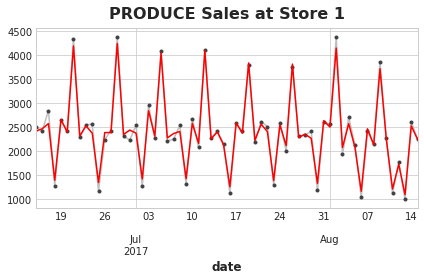

In [21]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'
# Uncomment to see a list of product families
display(store_sales.index.get_level_values('family').unique())

ax = y_train.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params) # choose single store 1 and family equal produce. 
ax = yLR_RF.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax, color='red')
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

y.info()

### Metrics

It's calculating metrics:

- Mean Absolute Error MAE
- Root Mean Squared Log Error RMSE

In [22]:
Y = y_train.loc(axis=1)['sales', STORE_NBR, FAMILY]
Ypred = yLR_RF.loc(axis=1)['sales', STORE_NBR, FAMILY]

yfit_lnr = pd.DataFrame(yLR_RF, index = Xtrain.index, columns = y_train.columns).clip(0.)

Mae = np.round(mae(Y, Ypred), 3)  
#Rmsle =  np.round(msle(Y, Ypred)**0.5, 3 )

In [23]:
y_pred2   = yLR_RF.stack(['store_nbr', 'family']).reset_index()
y_target = y_train.stack(['store_nbr', 'family']).reset_index().copy()

y_target['sales_pred'] = y_pred2['sales'].clip(0.) # Sales should be >= 0


print( y_target.groupby('family').apply(lambda r: np.sqrt(msle(r['sales'], r['sales_pred'] ))) )
print('RF+LNR RMSLE :', np.sqrt(  msle(y_train, yfit_lnr) ))

family
AUTOMOTIVE                    0.213714
BABY CARE                     0.098357
BEAUTY                        0.204526
BEVERAGES                     0.067806
BOOKS                         0.035127
BREAD/BAKERY                  0.052979
CELEBRATION                   0.241397
CLEANING                      0.115771
DAIRY                         0.046384
DELI                          0.058191
EGGS                          0.117872
FROZEN FOODS                  0.103158
GROCERY I                     0.047407
GROCERY II                    0.246711
HARDWARE                      0.221076
HOME AND KITCHEN I            0.200100
HOME AND KITCHEN II           0.180967
HOME APPLIANCES               0.138018
HOME CARE                     0.067400
LADIESWEAR                    0.191157
LAWN AND GARDEN               0.179591
LINGERIE                      0.278788
LIQUOR,WINE,BEER              0.244813
MAGAZINES                     0.209630
MEATS                         0.071527
PERSONAL CARE     

We seek, there is overfiting. 

# Test set

The test set, building with same variables the train set, it has 16 steps.

### Missing Values ###

In [24]:
df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()


average_sales_test = (
    df_test
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)


#df_test = df_test.loc['2017'] 
# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_testOil = dpOil.out_of_sample(steps=16)

X_test.index.name = 'date'

X_test1 = X_test.copy()




X_test1 = X_test1.join(calendar)



In [25]:
Xoil.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 56 entries, 2017-06-15 to 2017-08-31
Freq: D
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   const          56 non-null     float64
 1   trend          56 non-null     float64
 2   s(2,7)         56 non-null     float64
 3   s(3,7)         56 non-null     float64
 4   s(4,7)         56 non-null     float64
 5   s(5,7)         56 non-null     float64
 6   s(6,7)         56 non-null     float64
 7   s(7,7)         56 non-null     float64
 8   sin(1,freq=M)  56 non-null     float64
 9   cos(1,freq=M)  56 non-null     float64
 10  sin(2,freq=M)  56 non-null     float64
 11  cos(2,freq=M)  56 non-null     float64
 12  sin(3,freq=M)  56 non-null     float64
 13  cos(3,freq=M)  56 non-null     float64
 14  sin(4,freq=M)  56 non-null     float64
 15  cos(4,freq=M)  56 non-null     float64
dtypes: float64(16)
memory usage: 7.4 KB


Preparation Test set.

In [26]:
X_test1['Onpromotion'] = average_sales_test['onpromotion']
X_test1['salesLag7'] = average_sales.sales.shift(periods=16, freq='D')

In [27]:
X_test1.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,type_Holiday,type_Transfer,type_Work Day,school_season,Oil,oil_lags1,oil_lags2,oil_lags3,Onpromotion,salesLag7
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1.0,63.0,0.0,0.0,0.0,0.0,0.0,1.0,0.101168,-0.994869,...,0,0,0,1,48.281429,48.648572,48.934286,NaN,17.137486,497.113831
2017-08-17,1.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.101168,-0.994869,...,0,0,0,1,47.995714,48.281429,48.648572,48.934286,4.211560,554.729370
2017-08-18,1.0,65.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.299363,-0.954139,...,0,0,0,1,47.852857,47.995714,48.281429,48.648572,7.731201,541.364746
2017-08-19,1.0,66.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.485302,-0.874347,...,0,0,0,1,NaN,47.852857,47.995714,48.281429,4.833895,408.568176
2017-08-20,1.0,67.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.651372,-0.758758,...,0,0,0,1,NaN,NaN,47.852857,47.995714,5.338384,464.520599


In [28]:
X_test2 = X_test1.join( Xoil , on='date', rsuffix='RT').fillna(method = 'ffill')

In [29]:
X_test2.fillna(method='ffill', inplace=True)
X_test2.fillna(method='bfill', inplace=True)

X_test2.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,"s(6,7)RT","s(7,7)RT","sin(1,freq=M)RT","cos(1,freq=M)RT","sin(2,freq=M)RT","cos(2,freq=M)RT","sin(3,freq=M)RT","cos(3,freq=M)RT","sin(4,freq=M)RT","cos(4,freq=M)RT"
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1.0,63.0,0.0,0.0,0.0,0.0,0.0,1.0,0.101168,-0.994869,...,0.0,0.0,0.101168,-0.994869,-0.201299,0.979530,0.299363,-0.954139,-0.394356,0.918958
2017-08-17,1.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.101168,-0.994869,...,0.0,0.0,-0.101168,-0.994869,0.201299,0.979530,-0.299363,-0.954139,0.394356,0.918958
2017-08-18,1.0,65.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.299363,-0.954139,...,0.0,0.0,-0.299363,-0.954139,0.571268,0.820763,-0.790776,-0.612106,0.937752,0.347305
2017-08-19,1.0,66.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.485302,-0.874347,...,0.0,0.0,-0.299363,-0.954139,0.571268,0.820763,-0.790776,-0.612106,0.937752,0.347305
2017-08-20,1.0,67.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.651372,-0.758758,...,0.0,0.0,-0.299363,-0.954139,0.571268,0.820763,-0.790776,-0.612106,0.937752,0.347305


In [30]:
y_pred1 = modelB.predict(X_test2)
y_pred2 = modelRF.predict(X_test2)

print(y_pred1.shape, '\n ',  y_pred2.shape)

Predict Progress


  0%|          | 0/3564 [00:00<?, ?it/s]

(16, 3564) 
  (16, 3564)


In [31]:
y_final = y_pred2 + y_pred1


## Creation Submit



In [32]:
y_submit = pd.DataFrame(y_final, index=X_test2.index, columns=y.columns)

#y_submit = pd.DataFrame(model.predict(X_test2), index = X_test2.index, columns = y.columns).clip(0.)

y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

In [33]:

from datetime import datetime

now = datetime.now()
print('\n', now)



 2022-05-22 01:10:17.793391


File submit.

In [34]:
Xtrain.columns == X_test2.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [35]:
y_submit.head()


id        sales
date       store_nbr family                          
2017-08-16 1         AUTOMOTIVE  3000888     3.394856
                     BABY CARE   3000889     0.000000
                     BEAUTY      3000890     3.512388
                     BEVERAGES   3000891  2415.352908
                     BOOKS       3000892     0.097871

## Pre-Processing ##

### Selection only Giants or Dwarfs ###

## Balance ##

In [36]:
# dividir set 



# from sklearn.utils import resample
# dfGiantsDownSample = resample(dfGiants, 
  #                           replace = False, # sample without replacement
   #                          n_samples = num_of_dwarf,
   #                          random_state =1 
 #                            )
#dfDownSampled = pd.concat([dfGiantsDownSample , dfDwarfs] )

#dfBalanced= dfDownSampled.reset_index(drop=True)

# dataStar = dfBalanced.sample(frac=1).reset_index(drop=True) # shuffle
# dfCopyStar = dataStar.copy()

## Visualization ##

## Correlation Linear ##

## Data Cleaning ##

# **Data Processing** #

### Train and test Set ###

In [37]:
## Stratified ##
#from sklearn.model_selection import StratifiedShuffleSplit
#split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#for train_index, test_index in split.split(data, data["variableStratificada"]):
#strat_train_set = housing.loc[train_index]
#strat_test_set = housing.loc[test_index]

#from  sklearn.impute import SimpleImputer
#imputer = SimpleImputer(strategy='median')

#from  sklearn.preprocessing import OneHotEncoder
#catEncoder = OneHotEncoder()

## numerical ##
#from  sklearn.pipeline import Pipeline
#from  sklearn.preprocessing import StandardScaler
#numerical_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),('attribs_adder', CombinedAttributesAdder()),])
# new_variable_transformed_numerical = num_pipeline.fit_transform(varible_numerica)

## numerical and categorial ##
#from sklearn import ColumnTransformer
#numerical_attribs = list(numerical_columns)
#categorical_attribs = list(categorial_columns)
#full_pipeline = ColumnTransformer([("num", numerical_pipeline, numerical_attribs),("cat", OneHotEncoder(), categorical_attribs),])
#dataTotal_prepared = full_pipeline.fit_transform(dataTotal) 

## Target ## 

## Featuring Engineering ##

##  Pipeline and Featuring Scaling ##

 # **MODEL** # 

#### Models ####

In [38]:
### stratified CV ### see pag 136  Geron's book
#from sklearn.model_selection import StratifiedKFold
#from sklearn.base import clone
#skfolds = StratifiedKFold(n_splits=3, random_state=42)

# **Refinament** #

# **Deploy** #